/Users/vladyoslav/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset path: /Users/vladyoslav/.cache/kagglehub/datasets/rahmasleam/intel-image-dataset/versions/1/Intel Image Dataset


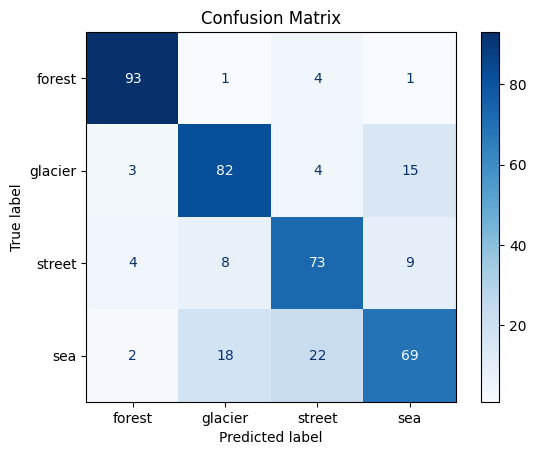

F1 Score: 0.77


In [1]:
import kagglehub
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from src import (
    ImageClassifier,
)
from src.utils import load_images_from_categories

# Load dataset
path = os.path.join(
    kagglehub.dataset_download("rahmasleam/intel-image-dataset"), "Intel Image Dataset"
)
print("Dataset path:", path)

categories = ImageClassifier.categories
images, labels = load_images_from_categories(path, categories)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Create the classifier
classifier = ImageClassifier()

# Train the model
classifier.fit(X_train, y_train)

# Predict using the classifier
y_pred_labels = [classifier.predict(image) for image in X_test]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels, labels=categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Evaluate classifier using F1 score
f1 = f1_score(y_test, y_pred_labels, average="weighted")
print(f"F1 Score: {f1:.2f}")